In [1]:
!pip install scanpy
!pip install decoupler
!pip install leidenalg
!pip install omnipath


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import decoupler as dc
from sklearn.metrics import davies_bouldin_score

READING DATA

In [2]:
adata = ad.read_h5ad('GTEX-1HSMQ-5005.h5ad')
ada = adata.copy()

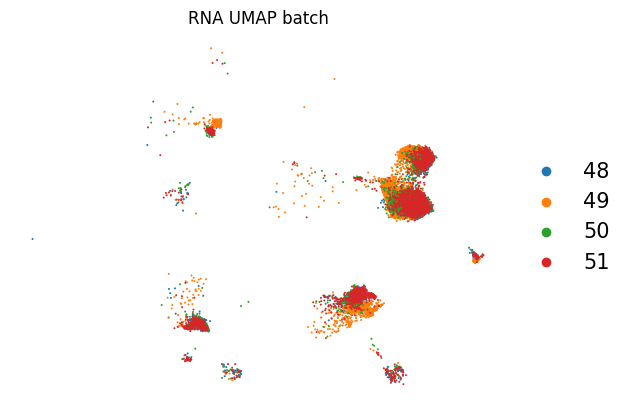

In [23]:
sc.pl.umap(ada, color='batch', title='RNA UMAP batch', frameon=False, legend_fontweight='normal', legend_fontsize=15)

PREPROCESSING

Preprocessing - Filtering data

In [24]:
sc.pp.filter_cells(ada, min_genes=200)
sc.pp.filter_genes(ada, min_cells=3)

In [25]:
ada.var['mt'] = ada.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(ada, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

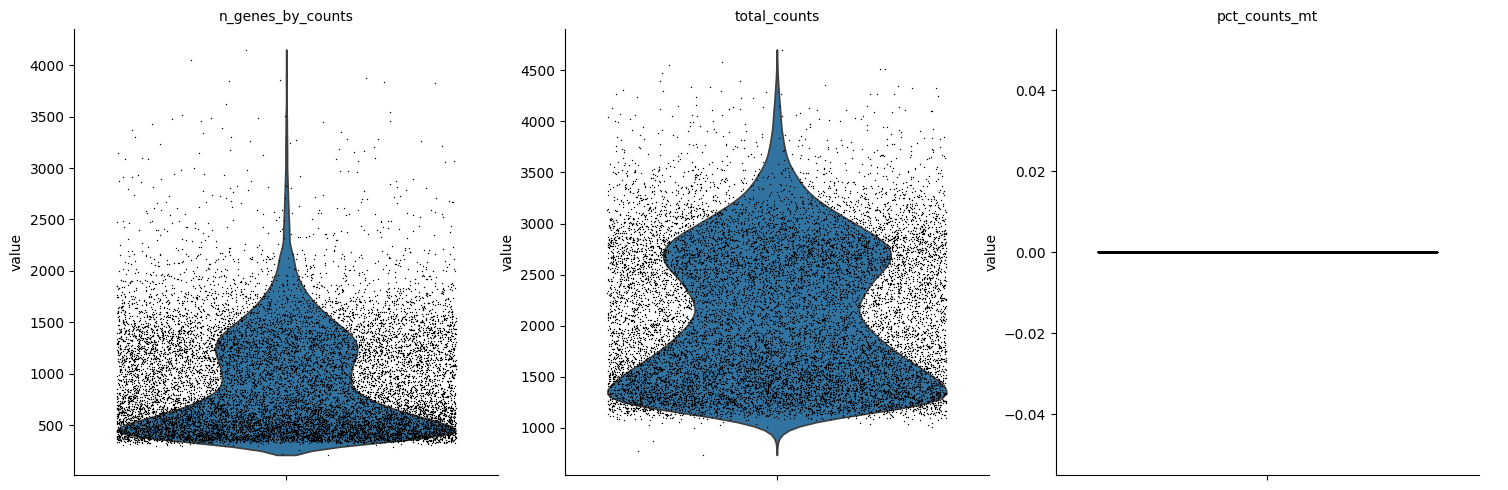

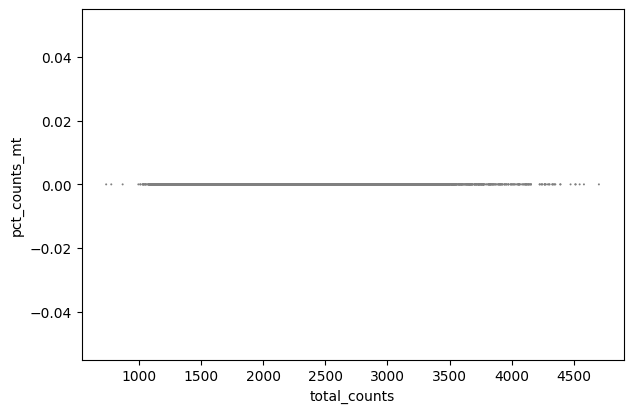

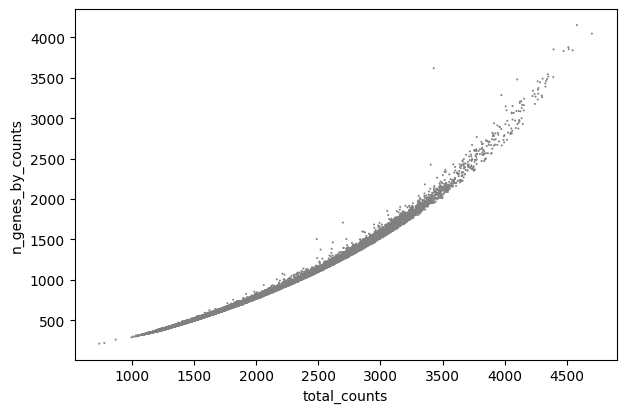

In [26]:
sc.pl.violin(ada, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(ada, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(ada, x="total_counts", y="n_genes_by_counts")

In [27]:
ada = ada[ada.obs.n_genes_by_counts < 2000, :]

Preprocessing - Normalization & Log transformation

In [28]:
# Normalize & log transform the data
sc.pp.normalize_total(ada, target_sum=1e4)
sc.pp.log1p(ada)
ada.layers['log_norm'] = ada.X.copy()

c:\Users\stoja\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Preprocessing – Highly variable genes

In [29]:
# Identify the highly variable genes
sc.pp.highly_variable_genes(ada, min_mean=0.0125, max_mean=3, min_disp=0.5)


In [30]:
# Regress and scale the data
sc.pp.regress_out(ada, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(ada, max_value=10)

Preprocessing - Dimensionality reduction

In [31]:
# Generate PCA features
sc.tl.pca(ada, svd_solver='arpack')

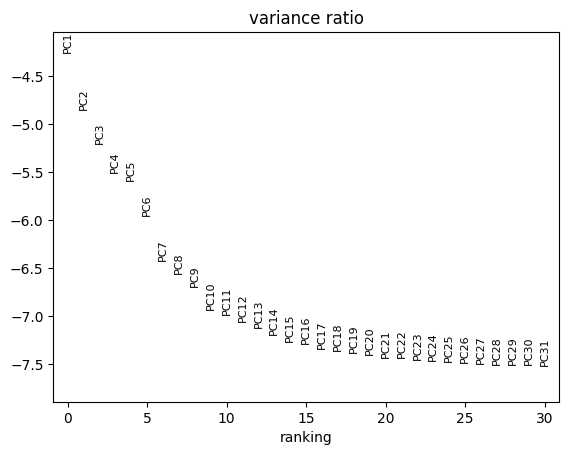

In [32]:
sc.pl.pca_variance_ratio(ada, log=True)

In [33]:
#Restore X to be norm counts
dc.swap_layer(ada, 'log_norm', X_layer_key=None, inplace=True)

Preprocessing - Neighbourhood graph

In [34]:
# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(ada, n_neighbors=10, n_pcs=40)

In [35]:
sc.tl.umap(ada)

CLUSTERING

Clustering with preprocessing

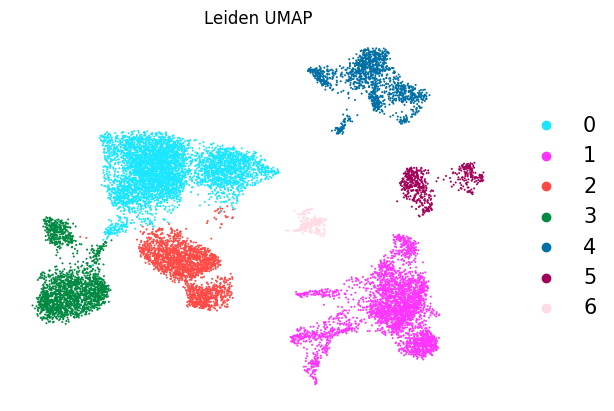

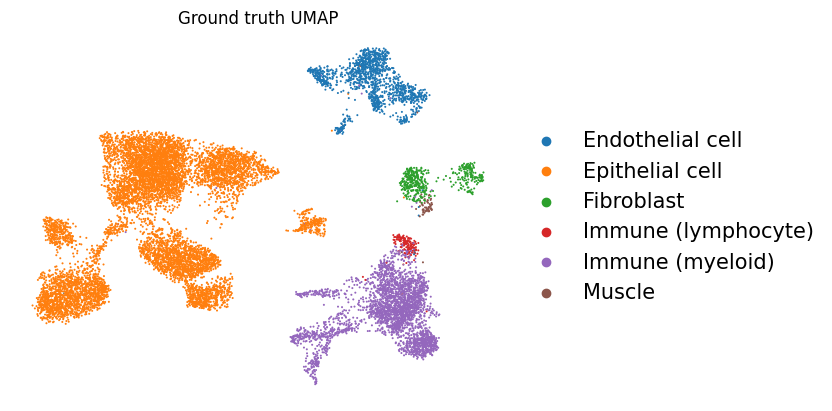

In [36]:
sc.tl.leiden(ada, resolution=0.1)

# Visualize
sc.pl.umap(ada, color='leiden', title='Leiden UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)
sc.pl.umap(ada, color='Cell types level 2', title='Ground truth UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [37]:
db_score = davies_bouldin_score(ada.obsm['X_umap'], ada.obs['leiden'].astype(int))
print(f"Davies-Bouldin score: {db_score}")

Davies-Bouldin score: 0.49062326747171076


Clustering without preprocessing

In [38]:
adaNoPre = adata.copy()

sc.tl.pca(adaNoPre, svd_solver='arpack')
sc.pp.neighbors(adaNoPre, n_neighbors=10, n_pcs=40)
sc.tl.umap(adaNoPre)

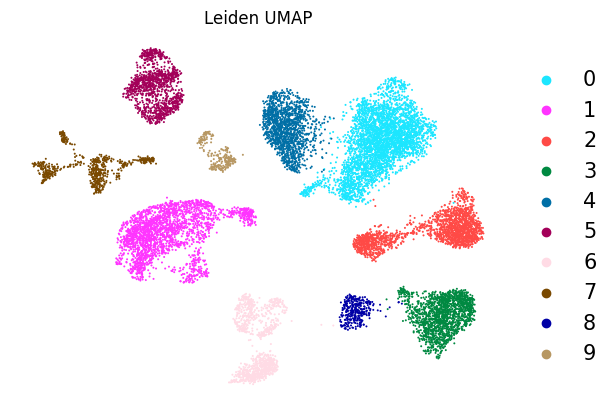

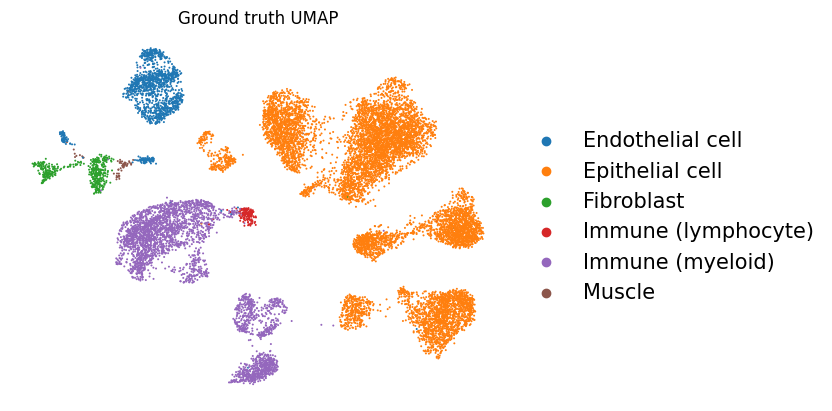

In [39]:
# Run leiden clustering algorithm
sc.tl.leiden(adaNoPre, resolution=0.1)

# Visualize
sc.pl.umap(adaNoPre, color='leiden', title='Leiden UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)
sc.pl.umap(adaNoPre, color='Cell types level 2', title='Ground truth UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [40]:
db_score = davies_bouldin_score(adaNoPre.obsm['X_umap'], adaNoPre.obs['leiden'].astype(int))
print(f"Davies-Bouldin score: {db_score}")

Davies-Bouldin score: 0.5602521263393494


The Davies-Bouldin Index (DBI) is a metric used to evaluate the quality of clustering algorithms. A lower DBI score indicates that clusters are well-separated and internally cohesive, which generally signifies better clustering performance.

Scores Analysis

    - Preprocessed Data (Filtering, Normalization, Selection of Highly Variable Genes, Dimensionality Reduction): The DBI score is 0.4906.
    - Raw Data (No Preprocessing): The DBI score is 0.5603.

The lower DBI score (0.4906) from the preprocessed data suggests that the preprocessing steps have significantly enhanced the quality of the clustering. 

The comparison of DBI scores clearly demonstrates the value of a thoughtful preprocessing pipeline in scRNA-seq data analysis. By preparing the data through filtering, normalization, focusing on highly variable genes, and reducing dimensionality, we can significantly enhance the quality of clustering, leading to more accurate biological interpretations and more robust downstream analyses.